# Competitor analysis: topic modelling of Bauldur's Gate 3 reviews on Steam

## Latent Dirichlet Allocation

In [9]:
# Import packages for LDA 


import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import CoherenceModel, LdaMulticore
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings


warnings.filterwarnings('ignore')

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/paula/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/paula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/paula/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/paula/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paula/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
import pandas as pd
from config import BG3_data_file_path

# Load data file
file_path = BG3_data_file_path
df = pd.read_csv(file_path)
#Show data frame's first 5 entries
df.head(5)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,146197289,"{'steamid': '76561198209057388', 'num_games_ow...",english,my work is really cutting into my Baldur's Gat...,1694565640,1694565640,True,7830,2987,0.980962,0,True,False,False,True,NaN
1,153859247,"{'steamid': '76561198412806684', 'num_games_ow...",english,You can convince bosses to kill themselves. 10/10,1702909919,1702909919,True,3605,900,0.980739,10,True,False,False,True,NaN
2,143924257,"{'steamid': '76561198022720435', 'num_games_ow...",english,Possessed a guard and had them open a gate con...,1691783669,1691783669,True,3124,1268,0.978952,12,True,False,False,True,NaN
3,146776206,"{'steamid': '76561198007607100', 'num_games_ow...",english,I have only one point of criticism:\nThis game...,1695386806,1701885967,True,1320,6,0.978480,28,True,False,False,True,NaN
4,143578821,"{'steamid': '76561198004904749', 'num_games_ow...",english,No microtransactions\nNo in-game purchases\nNo...,1691401740,1691401740,True,15452,51,0.978366,0,True,False,False,True,NaN


In [11]:
import ast

# Extract info stored in first column dictionary 
# Convert the 'author' column strings to dictionaries using ast.literal_eval
df['author'] = df['author'].apply(ast.literal_eval)

# Extract 'steamid' from the 'author' dictionaries
df['steamid'] = df['author'].apply(lambda x: x.get('steamid', None))

# Extract 'num_games_owned' from the 'author' dictionaries
df['num_games_owned'] = df['author'].apply(lambda x: x.get('num_games_owned', None))

# Extract 'num_reviews' from the 'author' dictionaries
df['num_reviews'] = df['author'].apply(lambda x: x.get('num_reviews', None))

# Extract 'playtime_forever' from the 'author' dictionaries
df['playtime_forever'] = df['author'].apply(lambda x: x.get('playtime_forever', None)/60)

# Extract 'playtime_at_review' from the 'author' dictionaries
df['playtime_at_review'] = df['author'].apply(lambda x: x.get('playtime_at_review', None)/60)

# Convert 'timestamp_created' to a date in the format YYYY-MM-DD
df['timestamp_created_date'] = pd.to_datetime(df['timestamp_created'], unit='s').dt.strftime('%Y-%m-%d')

# Create a new dataframe with the specified columns
new_df = df.loc[:,['review','playtime_at_review','num_games_owned','voted_up']]
new_df.head()

,review,playtime_at_review,num_games_owned,voted_up
0,my work is really cutting into my Baldur's Gat...,41.933333,0,True
1,You can convince bosses to kill themselves. 10/10,200.900000,95,True
2,Possessed a guard and had them open a gate con...,83.833333,0,True
3,I have only one point of criticism:\nThis game...,373.150000,353,True
4,No microtransactions\nNo in-game purchases\nNo...,27.900000,418,True


### EDA

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   review              500 non-null    object 
 1   playtime_at_review  500 non-null    float64
 2   num_games_owned     500 non-null    int64  
 3   voted_up            500 non-null    bool   
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 12.3+ KB


In [13]:
# Are there duplicates? How many?
new_df.duplicated(subset=['review']).sum()

5

In [14]:
# Basic summary statistics
new_df = new_df.drop_duplicates(subset=['review'])
new_df['review_length'] = new_df['review'].str.split().str.len()
new_df.describe()

,playtime_at_review,num_games_owned,review_length
count,495.000000,495.000000,495.000000
mean,115.905051,450.880808,138.785859
std,153.370717,1069.287632,254.556586
min,0.333333,0.000000,1.000000
25%,25.608333,0.000000,12.000000
50%,69.183333,109.000000,37.000000
75%,152.450000,452.000000,126.500000
max,1440.983333,11861.000000,1443.000000


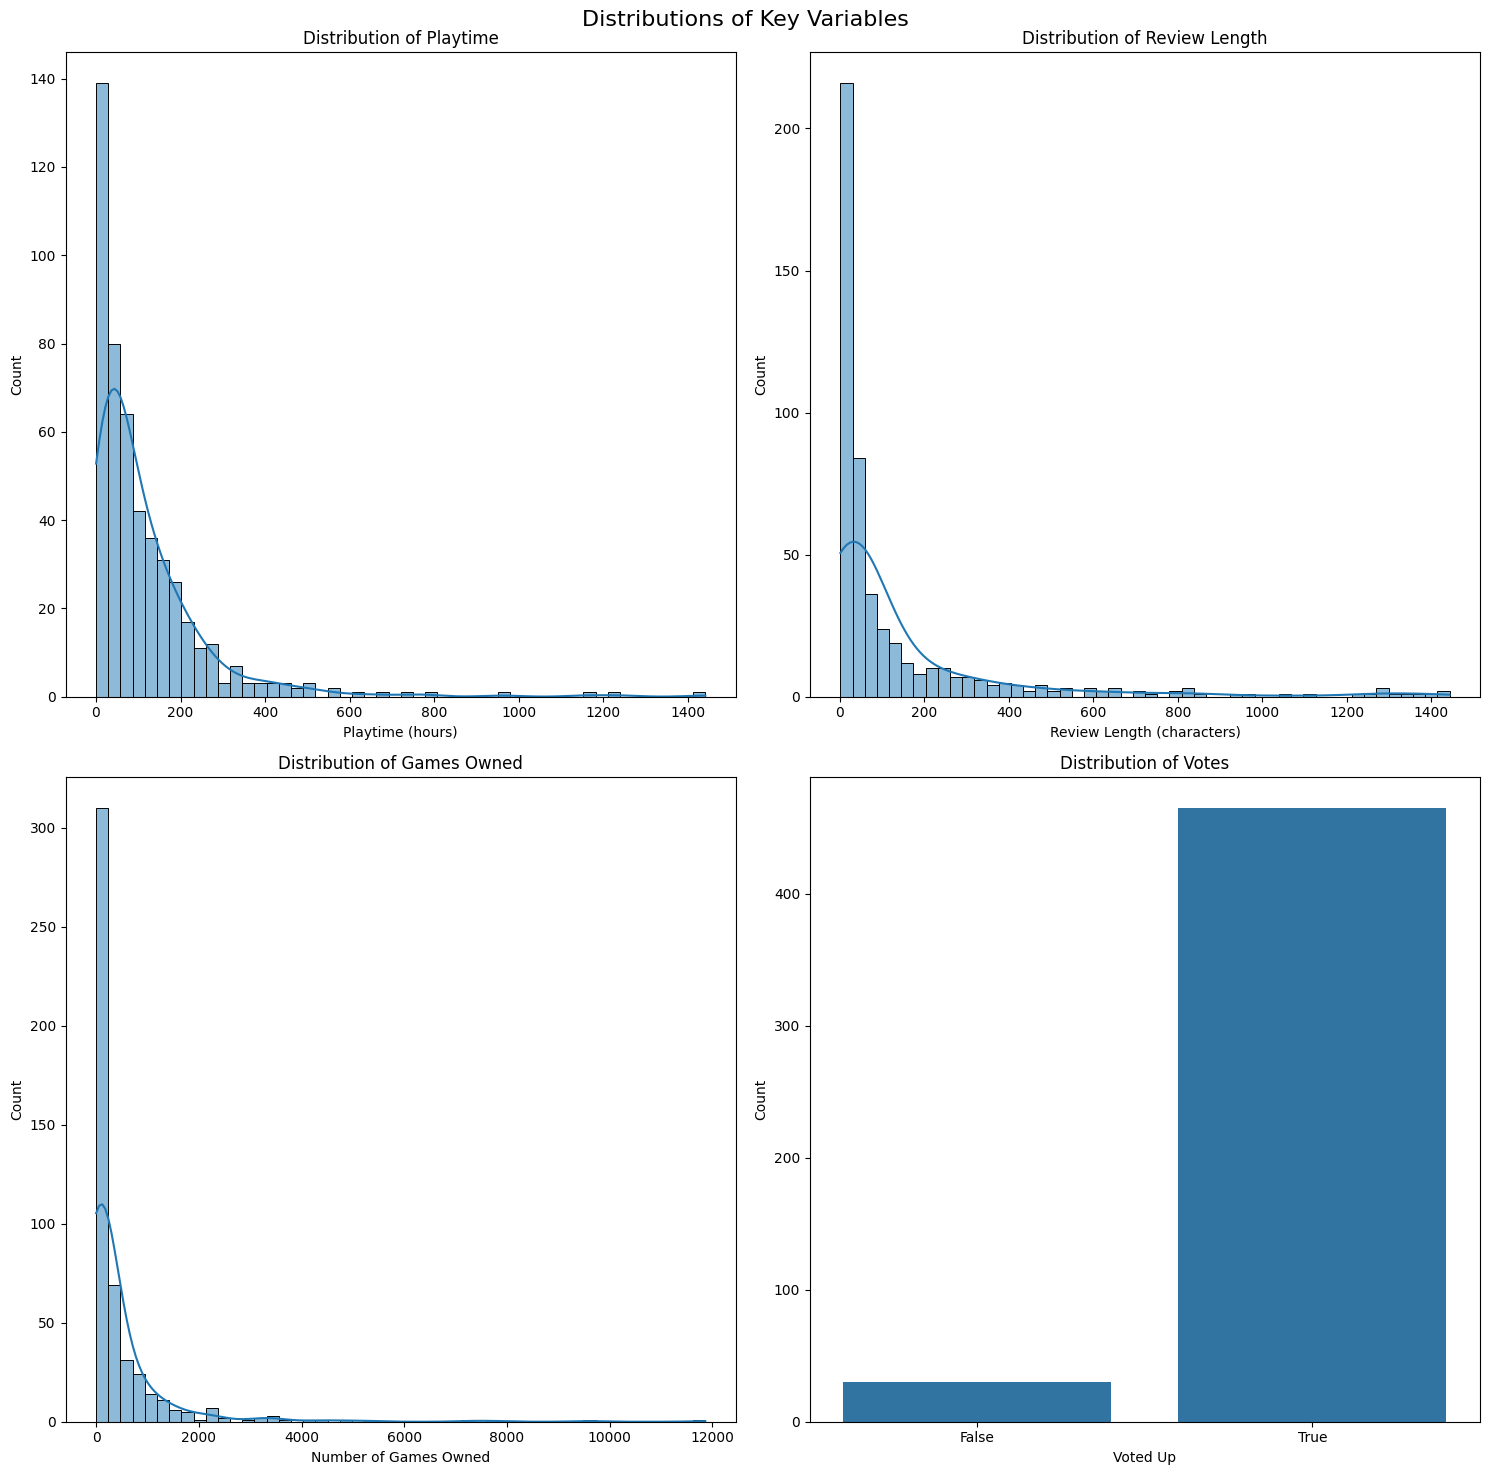

In [15]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Distributions of Key Variables', fontsize=16)

# Make subplots
sns.histplot(new_df['playtime_at_review'], bins=50, ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Distribution of Playtime')
axs[0, 0].set_xlabel('Playtime (hours)')
axs[0, 0].set_ylabel('Count')

sns.histplot(new_df['review_length'], bins=50, ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Distribution of Review Length')
axs[0, 1].set_xlabel('Review Length (characters)')
axs[0, 1].set_ylabel('Count')

sns.histplot(new_df['num_games_owned'], bins=50, ax=axs[1, 0], kde=True)
axs[1, 0].set_title('Distribution of Games Owned')
axs[1, 0].set_xlabel('Number of Games Owned')
axs[1, 0].set_ylabel('Count')

sns.countplot(x='voted_up', data=new_df, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Votes')
axs[1, 1].set_xlabel('Voted Up')
axs[1, 1].set_ylabel('Count')

# Display plots
plt.tight_layout()
plt.show()

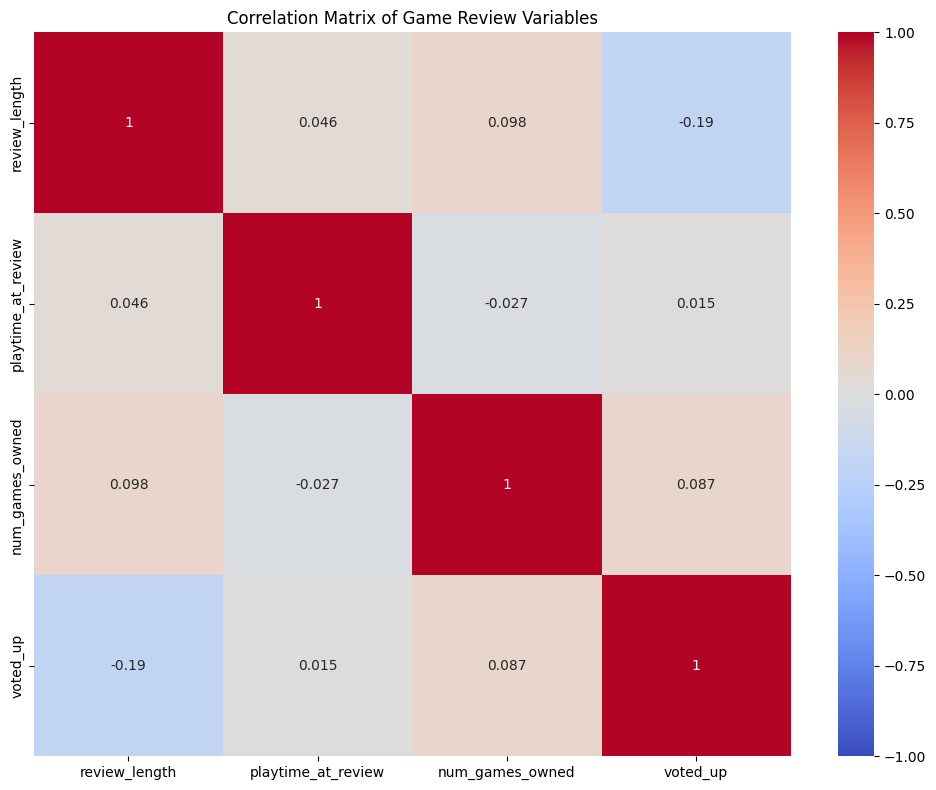

In [16]:
# Convert 'voted_up' to numeric
new_df['voted_up'] = new_df['voted_up'].astype(int)

# Create a new dataframe with only the numeric columns
numeric_df = new_df[['review_length', 'playtime_at_review', 'num_games_owned', 'voted_up']]

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Game Review Variables')
plt.tight_layout()
plt.show()

No variables really correlated with other variables

ValueError: We need at least 1 word to plot a word cloud, got 0.

### Text preprocessing 

In [20]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URL addresses
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Replace punctuation and hyphens with spaces
    text = re.sub(r'[^\w\s]|_|-', ' ', text)
    
    # Remove non-alphabetic characters (keeping spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords, lemmatize, and remove isolated letters
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the 'review' column
new_df['processed_review'] = new_df['review'].apply(preprocess_text)

In [21]:
# Visualize the dataframe with new column
new_df.head()

,review,playtime_at_review,num_games_owned,voted_up,review_length,processed_review
0,my work is really cutting into my Baldur's Gat...,41.933333,0,1,14,work really cutting baldur gate time quit
1,You can convince bosses to kill themselves. 10/10,200.900000,95,1,8,convince boss kill
2,Possessed a guard and had them open a gate con...,83.833333,0,1,40,possessed guard open gate containing giant spi...
3,I have only one point of criticism:\nThis game...,373.150000,353,1,107,one point criticism game lack proper ending ep...
4,No microtransactions\nNo in-game purchases\nNo...,27.900000,418,1,33,microtransactions game purchase paywalls game ...


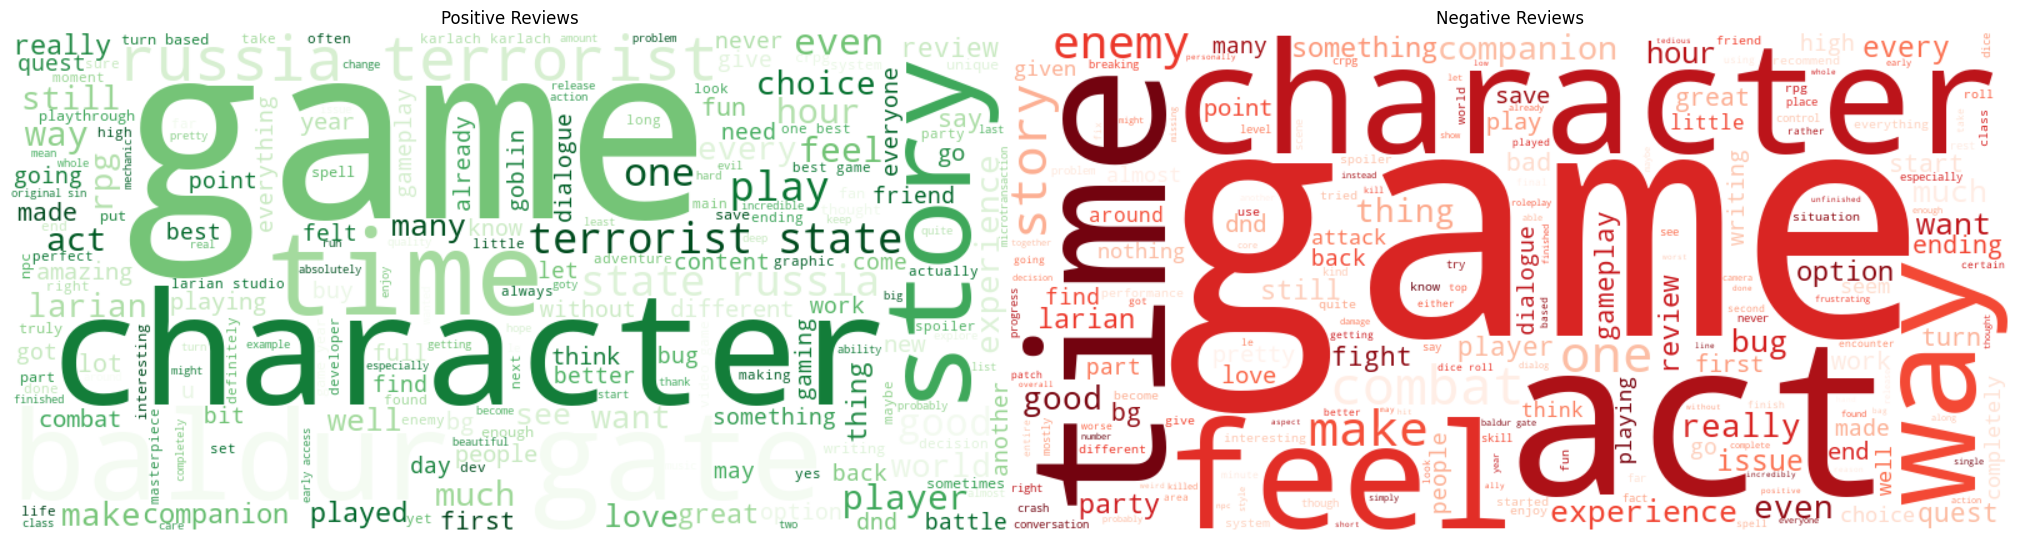

In [25]:
# Word cloud for positive reviews (assuming you have a 'rating' column)
positive_reviews = ' '.join(new_df[new_df['voted_up'] == 1]['processed_review'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                               colormap='Greens').generate(positive_reviews)

# Word cloud for negative reviews
negative_reviews = ' '.join(new_df[new_df['voted_up'] != 1]['processed_review'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                               colormap='Reds').generate(negative_reviews)

# Display both word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Positive Reviews')
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Negative Reviews')
plt.tight_layout(pad=0)
plt.show()

### Document-term matrix

In [22]:
# Create term frequency matrix
count_vectorizer = CountVectorizer(min_df=0.1, max_df=0.95)
tf_matrix = count_vectorizer.fit_transform(new_df['processed_review'])

# Get feature names
tf_feature_names = count_vectorizer.get_feature_names_out()

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(new_df['processed_review'])

# Get feature names for TF-IDF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert sparse matrices to dataframe for easier viewing
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=tf_feature_names)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Print basic information
print("Term Frequency Matrix Shape:", tf_matrix.shape)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Number of unique terms:", len(tf_feature_names))

# Display a sample of the TF-IDF matrix (first 5 rows, first 5 columns)
print("\nSample of TF-IDF Matrix:")
print(tfidf_df.iloc[:5, :5])

Term Frequency Matrix Shape: (495, 54)
TF-IDF Matrix Shape: (495, 5699)
Number of unique terms: 54

Sample of TF-IDF Matrix:
   aaa  aaaa  abandoned  ability  able
0  0.0   0.0        0.0      0.0   0.0
1  0.0   0.0        0.0      0.0   0.0
2  0.0   0.0        0.0      0.0   0.0
3  0.0   0.0        0.0      0.0   0.0
4  0.0   0.0        0.0      0.0   0.0


In [13]:
# Convert the preprocessed reviews into a list of lists of words
texts = [review.split() for review in new_df['processed_review']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Create corpus
corpus = [dictionary.doc2bow(text) for text in texts]

### LDA hyperparameter tuning and modeling

Manually run different hyperparameters and topic numbers, exploring also the plot output to ensure topics make sense and are interpretable

In [14]:
# Function to train LDA model, uninspiringly named 
def train_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes, chunksize):
    """
    Train an LDA model with given parameters
    
    Parameters:
    ----------
    corpus : Gensim corpus
    dictionary : Gensim dictionary
    texts : List of preprocessed texts
    num_topics : int, number of topics
    alpha : float or 'auto', document-topic density
    eta : float or 'auto', topic-word density
    passes : int, number of passes through the corpus during training
    chunksize : int, number of documents to be used in each training chunk
    
    Returns:
    -------
    LDA model, coherence score
    """
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        chunksize=chunksize,
        passes=passes,
        alpha=alpha,
        eta=eta,
        workers=2
    )
    
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    return model, coherence_score

def print_model_results(model, coherence, num_topics, alpha, eta):
    print(f"\nModel parameters:")
    print(f"Number of topics: {num_topics}")
    print(f"Alpha: {alpha}")
    print(f"Eta: {eta}")
    print(f"Coherence Score: {coherence}")

num_topics = 12
alpha = 0.05
eta = 0.05
passes = 200
chunksize = 500

model, coherence = train_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes, chunksize)
print_model_results(model, coherence, num_topics, alpha, eta)

# Visualize topic distributions using pyLDAvis

# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# Save the visualization as an HTML file, optional 
# Remove hash below to run
# pyLDAvis.save_html(vis_data, 'lda_visualization.html')

# Visualize
pyLDAvis.display(vis_data)


Model parameters:
Number of topics: 12
Alpha: 0.05
Eta: 0.05
Coherence Score: 0.33967275991141815


There are some topics with strange terms. I want to manually inspect the reviews that contain those words, find their row number, and depending on their content, potentially delete them as outliers.

In [15]:
# Search for 'lego' and 'yoda'
# Specify the column and the list of strings to search for
column_to_search = 'review'
search_strings = ['lego', 'yoda']

# Locate the rows containing any of the specific strings
mask = new_df[column_to_search].str.contains('|'.join(search_strings), case=False, na=False)
filtered_df = new_df[mask]

# Get the row numbers of the filtered rows
row_indices = filtered_df.index.tolist()

# Display the row numbers
print(f"Row numbers containing the specified strings: {row_indices} \n")
pd.set_option('display.max_colwidth', None)
filtered_df['review']

Row numbers containing the specified strings: [458] 



458    I picked up and threw a goblin into a floor of fire, and it made a lego Yoda scream as it flew through the air and hit the flames. 10/10 GOTY.
Name: review, dtype: object

In [16]:
# Sounds pretty random, drop the filtered row from the dataframe
new_df_cleaned = new_df.drop(row_indices)

In [17]:
# Search for 'russia'
# Specify the column and the list of strings to search for
column_to_search = 'review'
search_strings = ['russia']

# Locate the rows containing any of the specific strings
mask = new_df_cleaned[column_to_search].str.contains('|'.join(search_strings), case=False, na=False)
filtered_df = new_df_cleaned[mask]

# Get the row numbers (indices) of the filtered rows
row_indices = filtered_df.index.tolist()

# Display the row numbers
print(f"Row numbers containing the specified strings: {row_indices} \n")
pd.set_option('display.max_colwidth', None)
filtered_df['review']

Row numbers containing the specified strings: [31] 



31    Baldur's Gate 3 is an excellent game. I haven't enjoyed a game this much since I was a kid playing Dragon Age for the first time. Everything is so well-thought-out, down to the smallest detail. You can play alone or with friends, and you can choose to be a force for good or chaos. Just be prepared to read a lot of text and enjoy the ride.\n\nHere are some of the things I love about Baldur's Gate 3:\n\nThe story is engaging and full of twists and turns.The characters are well-developed and relatable.The combat is challenging and rewarding.The world is vast and full of secrets to discover.\n\nIf you're a fan of role-playing games, then Baldur's Gate 3 is a must-play. It's an epic adventure that will keep you hooked for hours on end.\n\n5/5 parasites\n\nRUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS

In [18]:
# Looks like a legit review with some anti-Russia hate
# Remove whole string from review and processed review
new_df_cleaned = new_df_cleaned.replace(['RUSSIA IS A TERRORIST STATE!','russia terrorist state'], '', regex=True)
# Displayed cleaned row 31
pd.set_option('display.max_colwidth', 75)
new_df_cleaned[mask]

,review,playtime_at_review,num_games_owned,voted_up,review_length,processed_review
31,Baldur's Gate 3 is an excellent game. I haven't enjoyed a game this muc...,8.716667,124,1,826,baldur gate excellent game enjoyed game much since kid playing dragon a...


In [19]:
# Search for 'pizza'
# Specify the column and the list of strings to search for
column_to_search = 'review'
search_strings = ['pizza']

# Locate the rows containing any of the specific strings
mask = new_df_cleaned[column_to_search].str.contains('|'.join(search_strings), case=False, na=False)
filtered_df = new_df_cleaned[mask]

# Get the row numbers (indices) of the filtered rows
row_indices = filtered_df.index.tolist()

# Display the row numbers
print(f"Row numbers containing the specified strings: {row_indices} \n")
pd.set_option('display.max_colwidth', None)
filtered_df['review']

Row numbers containing the specified strings: [463] 



463    New York styled Pizza:\nPizza dough:\n14 g instant yeast\n617g water - 95F\n950g all-purpose flour\n19g fine sea salt\n25g granulated sugar\nAmerican Pizza Sauce and Toppings:\n1 tablespoon (14g) butter\n1 tablespoon (9g) extra virgin olive oil\n6 cloves garlic, rough chopped\n2 teaspoons (4g) red pepper flakes\n28 oz (794g) can of crushed tomato\n2 teaspoons (2g) dried oregano\n1.5 tablespoons (21g) granulated sugar\nsalt and pepper to taste\nSplash of olive oil\n2 cups (227g) low moisture mozzarella, fresh grated\n2 cups (200g) Monterey jack cheese, fresh grated\n1/2 cup (26g) parmigiano reggiano, fresh grated\nAmerican Pizza Dough:\nPreheat the oven and a baking steel or pizza stone at 500F for 45 minutes before utilizing it.\nWhisk yeast and sugar into your water, and allow it to sit for 5 minutes. In a separate bowl, add flour and salt and mix by hand to combine. Pour your water mixture into your flour and mix by hand until you get a rough dough, then transfer to a work sur

In [20]:
# Looks like a recipe for pizza...
# Drop the filtered row from the dataframe
new_df_cleaned = new_df_cleaned.drop(row_indices)

### New LDA with cleaned dataset

Redo steps of LDA model with cleaned dataset, recycled code

In [21]:
# Create term frequency matrix
count_vectorizer = CountVectorizer(min_df=0.1, max_df=0.95)
tf_matrix = count_vectorizer.fit_transform(new_df_cleaned['processed_review'])

# Get feature names (terms)
tf_feature_names = count_vectorizer.get_feature_names_out()

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(new_df_cleaned['processed_review'])

# Get feature names (terms) for TF-IDF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert sparse matrices to dataframe for easier viewing
tf_df = pd.DataFrame(tf_matrix.toarray(), columns=tf_feature_names)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

# Print basic information
print("Term Frequency Matrix Shape:", tf_matrix.shape)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Number of unique terms:", len(tf_feature_names))

# Display a sample of the TF-IDF matrix (first 5 rows, first 5 columns)
print("\nSample of TF-IDF Matrix:")
print(tfidf_df.iloc[:5, :5])

Term Frequency Matrix Shape: (493, 54)
TF-IDF Matrix Shape: (493, 5621)
Number of unique terms: 54

Sample of TF-IDF Matrix:
   aaa  aaaa  abandoned  ability  able
0  0.0   0.0        0.0      0.0   0.0
1  0.0   0.0        0.0      0.0   0.0
2  0.0   0.0        0.0      0.0   0.0
3  0.0   0.0        0.0      0.0   0.0
4  0.0   0.0        0.0      0.0   0.0


In [22]:
# Convert the preprocessed reviews into a list of lists of words
texts = [review.split() for review in new_df_cleaned['processed_review']]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# Create corpus
corpus = [dictionary.doc2bow(text) for text in texts]

In [23]:
num_topics = 11
alpha = 0.5
eta = 0.05
passes = 200
chunksize = 500

model, coherence = train_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes, chunksize)
print_model_results(model, coherence, num_topics, alpha, eta)

# Visualize topic distributions using pyLDAvis

# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# Visualize
pyLDAvis.display(vis_data)


Model parameters:
Number of topics: 11
Alpha: 0.5
Eta: 0.05
Coherence Score: 0.3686546507862971


### Topic names

Here we decide what names to give each collection of terms (topic) picked out by the model

**Topic 1**: "Game mechanics and storytelling"  focuses on core game elements like characters, story, companions, quests, and player choices.

**Topic 2**: "Player engagement and time investment"  highlights player engagement, time spent playing, and overall positive sentiment towards the game.

**Topic 3**: "RPG elements and world-building"  focuses on the RPG aspects of the game, including character choices, companions, and the game world.

**Topic 4**: "Game development and player expectations"  seems to cover aspects of the game's development, player expectations, and how it compares to previous titles in the series.

**Topic 5**: "Emotional impact and experience"  emphasizes the emotional connection players have with the game and its overall quality as an experience.

**Topic 6**: "Developer recognition and genre impact"  discusses Larian Studios and the game's impact on the RPG genre, comparing it to other notable titles.

**Topic 7**: "CRPG Mechanics"  focuses on specific CRPG (Computer Role-Playing Game) elements like dice rolls, party mechanics, and combat.

**Topic 8**: "Game impact on players“  emphasizes the game's impact on players, discussing it as one of the best gaming experiences.

**Topic 9**: "General game quality assessment"  seems to cover various aspects of the game's quality, including story, gameplay, graphics, and value for money.

**Topic 10**: "Controversial content"  seems to cover various player reactions, including some controversial or unexpected elements (e.g., sex, pets, gay content).

**Topic 11**: "Character appreciation"  highlights specific characters (Karlach, Shadowheart, Astarion) and suggests strong positive sentiment (GOTY - Game of the Year).